In [231]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import  lfilter, medfilt, butter, sosfiltfilt, find_peaks;
import pandas as pd
import glob , os
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler,StandardScaler

from scipy.io import loadmat ,savemat

# --------- File loading and preprocessing ---------


In [225]:

def find_csv(base_path):
    # Look only in the base folder (not subfolders)
    matches = glob.glob(os.path.join(base_path, "*.csv"))
    return matches

base = r"C:\Users\emire\OneDrive\Desktop\resp\Pig\Pig2\SignalsCSV"
paths = find_csv(base)

freq = 2048
print(paths)

filename = paths[2]
print('-----------------------------------------------')
print(f"CSV: {os.path.basename(filename)}")


# Path to filtered respiration data files and list of bad channels
# Load the filtered signal from CSV and transpose it
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
df = pd.read_csv(filename, sep=',')
print(filename)



['C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EndoPacingSite-LV-Apex.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EndoPacingSite-RA.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EndoPacingSite-RV-Apex.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EndoPacingSite-RV-OutflowTract.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EndoPacingSite-RV-Septum.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EpiPacingSite-12.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EpiPacingSite-131.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EpiPacingSite-147.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EpiPacingSite-149.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\SignalsCSV\\EpiPacingSite-156.csv', 'C:\\Users\\emire\\OneDrive\\Desktop\\resp\\Pig\\Pig2\\Signa

In [226]:

start = int(1*100)
stop = int(100)

Y = df.to_numpy(copy=True)
Y = Y[ :,start:(-stop)]
print(Y.shape)

time = np.linspace(0, df.shape[1] / freq, df.shape[1])
time = time[start:(-stop)]
print(time.shape)

# Step 1: Apply FIR filter to each row using lfilter
# lfilter does not natively broadcast over axis 0, so we use list comprehension or a matrix operation
h = [0.1, 0.2, 0.0, -0.2, -0.1]
H = np.array(h)
Y_filtered = np.apply_along_axis(lambda row: lfilter(H, 1.0, row), axis=1, arr=Y)




(149, 15774)
(15774,)


In [227]:

windowsize = int(100)
# Step 2: Square the filtered signal
Y_squared = Y_filtered ** 2
# Step 3: Moving average (via convolution), applied row-wise
kernel = np.ones(windowsize) / windowsize
Y_baseline = np.apply_along_axis(lambda row: np.convolve(row, kernel, mode='same'), axis=1, arr=Y_squared)
Y_smoothed = sosfiltfilt(butter(2, 0.5/(freq/2), 'lowpass', output='sos'), Y_baseline)

min_distance_qrs_ms = 10

mean_smoothed_Rpeak = np.mean(Y_baseline, axis=0)

rpeaks_outside , _ = find_peaks(
    mean_smoothed_Rpeak, 
    prominence=0.0001, 
    distance=min_distance_qrs_ms / 1000 * freq,
    height=0.2 * np.max(mean_smoothed_Rpeak)  # seuil minimum en valeur absolue
)


mean_smoothed_respiration = np.mean(Y_smoothed, axis=0)  # Shape: (n_samples,)







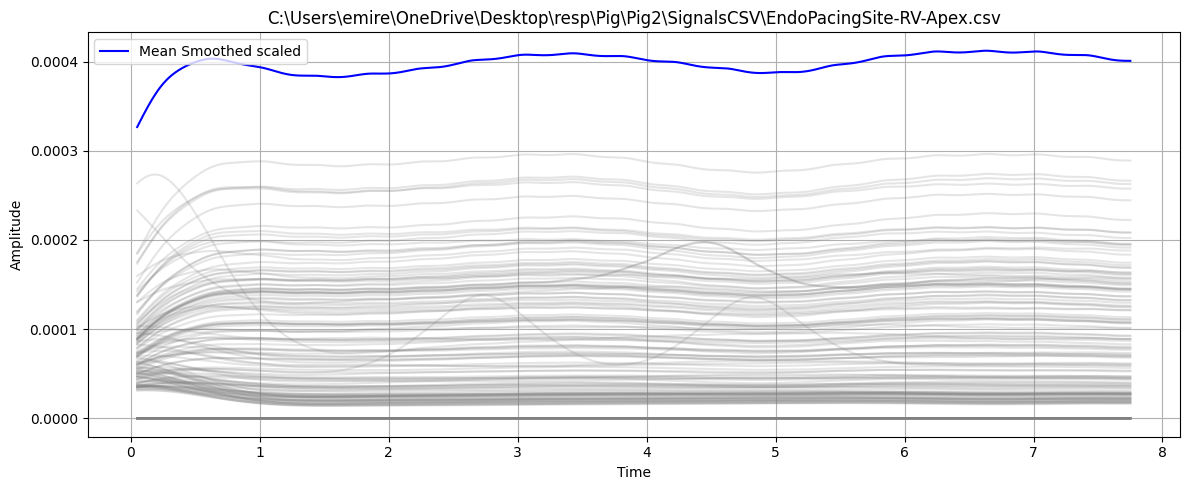

In [230]:

plottingplotplot = np.mean(Y_smoothed, axis=0)

plt.figure(figsize=(12, 5))

# Plot all original signals (absolute value) in gray
for i in range(Y.shape[0]):
    #plt.plot(time, np.abs(Y[i,:]), alpha=0.2, color='gray')
    plt.plot(time, (Y_smoothed[i,:]), alpha=0.2, color='gray')

Scalerforvis = 5 #(Y.max())/(plottingplotplot.max()*2)


# Plot mean smoothed
plt.plot(time, (plottingplotplot*Scalerforvis) , label='Mean Smoothed scaled', color='blue')

plt.title(f"{filename}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc=2)
plt.tight_layout()
plt.show()

plt.close()


In [192]:
rpeaks_outside_ms = time[rpeaks_outside]

(-1.0, 1.0)

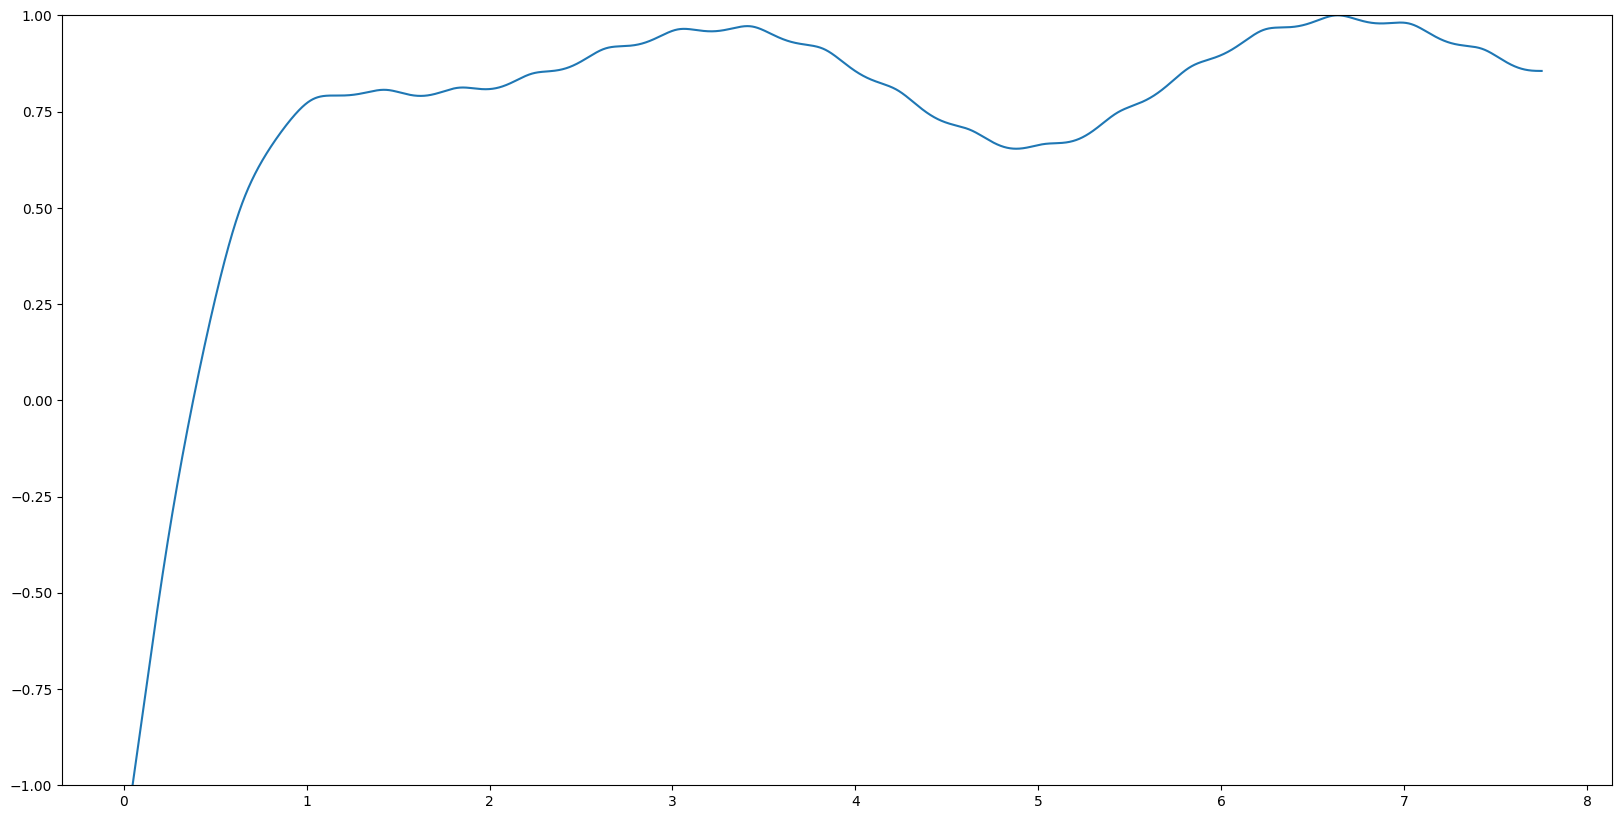

In [242]:
pca = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=5))
])
RRamp_for_pca = Y_smoothed
# Fit PCA on the transposed RRAmplitude (features in columns) and transform the data
pca_RRamp = pca.fit_transform(RRamp_for_pca.T)
# Select which PCA component to use (e.g., 0 = first principal component)
n_component = 0

# Normalize the selected PCA component to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
pca_RRamp_normalized = scaler.fit_transform(
    pca_RRamp[:, n_component].reshape(-1, 1)  # Reshape to 2D for scaler
).flatten()  # Flatten back to 1D after scaling

# Create a large figure and plotting axis
ax = plt.figure(figsize=[20, 10]).subplots()

# Plot the normalized PCA projection against the time of R-peaks
ax.plot(time, pca_RRamp_normalized)

# Set Y-axis limits to match the normalization range
ax.set_ylim([-1, 1])


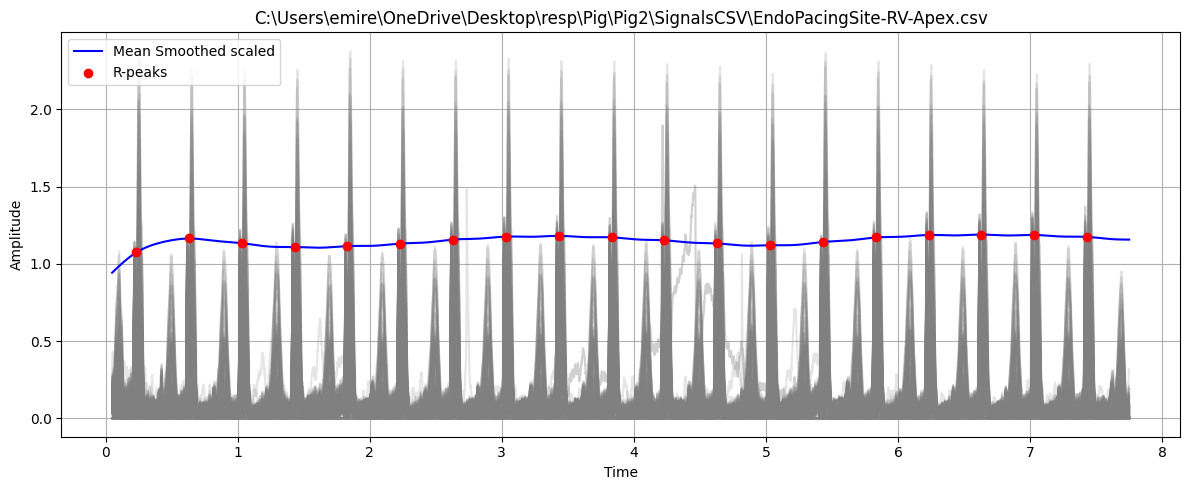

In [193]:


plt.figure(figsize=(12, 5))

# Plot all original signals (absolute value) in gray
for i in range(Y.shape[0]):
    plt.plot(time, np.abs(Y[i,:]), alpha=0.2, color='gray')


Scalerforvis = (Y.max())/(mean_smoothed_respiration.max()*2)


# Plot mean smoothed
plt.plot(time, (mean_smoothed_respiration*Scalerforvis) , label='Mean Smoothed scaled', color='blue')

plt.scatter(rpeaks_outside_ms, mean_smoothed_respiration[rpeaks_outside]*Scalerforvis, c='r', label='R-peaks',zorder=2.5)

    
plt.title(f"{filename}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc=2)
plt.tight_layout()
plt.show()

plt.close()


In [194]:
def select_peaks_near_extreme_amplitude(part, time_high_peaks, amplitude_percent=0.2):
    """
    Identify R-peaks that fall within ±20% of the amplitude near respiratory peaks and troughs.

    Parameters:
        part: 1D numpy array
            The respiratory signal (e.g., PCA-resampled respiration).
        time_high_peaks: list or array
            Indices of R-peaks to classify.
        amplitude_percent: float
            The proportion of the peak-to-trough amplitude to define the zone (default = 20%).

    Returns:
        df_top: DataFrame of R-peaks near the top 20% amplitude
        df_bottom: DataFrame of R-peaks near the bottom 20% amplitude
        df_outside: DataFrame of R-peaks outside the 20% amplitude zones
    """

    # Normalize the respiratory signal to [0, 1] range
    scaler = MinMaxScaler()
    resp_norm = scaler.fit_transform(part.reshape(-1, 1)).flatten()

    # Detect peaks (maxima) and troughs (minima) in the respiration
    peaks, _ = find_peaks(resp_norm, prominence=0.3, distance=500)
    troughs, _ = find_peaks(-resp_norm, prominence=0.3, distance=500)

    # Lists to collect R-peaks
    rpeaks_top = []
    rpeaks_bottom = []
    rpeaks_outside = []

    # Plot the normalized respiratory signal
    plt.figure(figsize=(20, 6))
    plt.plot(resp_norm, label="Normalized Respiration")
    plt.scatter(peaks, resp_norm[peaks], c='red', label='Peaks')
    plt.scatter(troughs, resp_norm[troughs], c='blue', label='Troughs')

    for rpeak in time_high_peaks:
        if len(peaks) == 0 or len(troughs) == 0:
            continue

        # Find closest peak and trough
        closest_peak = peaks[np.argmin(np.abs(peaks - rpeak))]
        closest_trough = troughs[np.argmin(np.abs(troughs - rpeak))]

        # Determine local amplitude range
        amp = resp_norm[closest_peak] - resp_norm[closest_trough]

        if abs(closest_peak - rpeak) < abs(closest_trough - rpeak):
            # Closer to peak → top zone
            threshold = resp_norm[closest_peak] - amplitude_percent * amp
            if resp_norm[rpeak] >= threshold:
                rpeaks_top.append(rpeak)
                plt.axhspan(threshold, 1, xmin=rpeak/len(resp_norm), xmax=(rpeak+1)/len(resp_norm),
                            color='green', alpha=0.2, label='Top ±20% amp' if len(rpeaks_top) == 1 else "")
            else:
                rpeaks_outside.append(rpeak)
        else:
            # Closer to trough → bottom zone
            threshold = resp_norm[closest_trough] + amplitude_percent * amp
            if resp_norm[rpeak] <= threshold:
                rpeaks_bottom.append(rpeak)
                plt.axhspan(0, threshold, xmin=rpeak/len(resp_norm), xmax=(rpeak+1)/len(resp_norm),
                            color='purple', alpha=0.2, label='Bottom ±20% amp' if len(rpeaks_bottom) == 1 else "")
            else:
                rpeaks_outside.append(rpeak)

    # Plot classified R-peaks
    plt.scatter(rpeaks_top, resp_norm[rpeaks_top], c='darkgreen', label='R-peaks top 20% amplitude')
    plt.scatter(rpeaks_bottom, resp_norm[rpeaks_bottom], c='indigo', label='R-peaks bottom 20% amplitude')
    plt.scatter(rpeaks_outside, resp_norm[rpeaks_outside], c='r', label='R-peaks outside 20% zones')

    plt.title("R-peaks within ±20% amplitude zones near respiratory extremes")
    plt.legend()
    plt.grid(True)
    plt.show()

    df_top = pd.DataFrame(sorted(set(rpeaks_top)), columns=['rpeaks_top_20_amp'])
    df_bottom = pd.DataFrame(sorted(set(rpeaks_bottom)), columns=['rpeaks_bottom_20_amp'])
    df_outside = pd.DataFrame(sorted(set(rpeaks_outside)), columns=['rpeaks_outside'])

    return df_top, df_bottom, df_outside

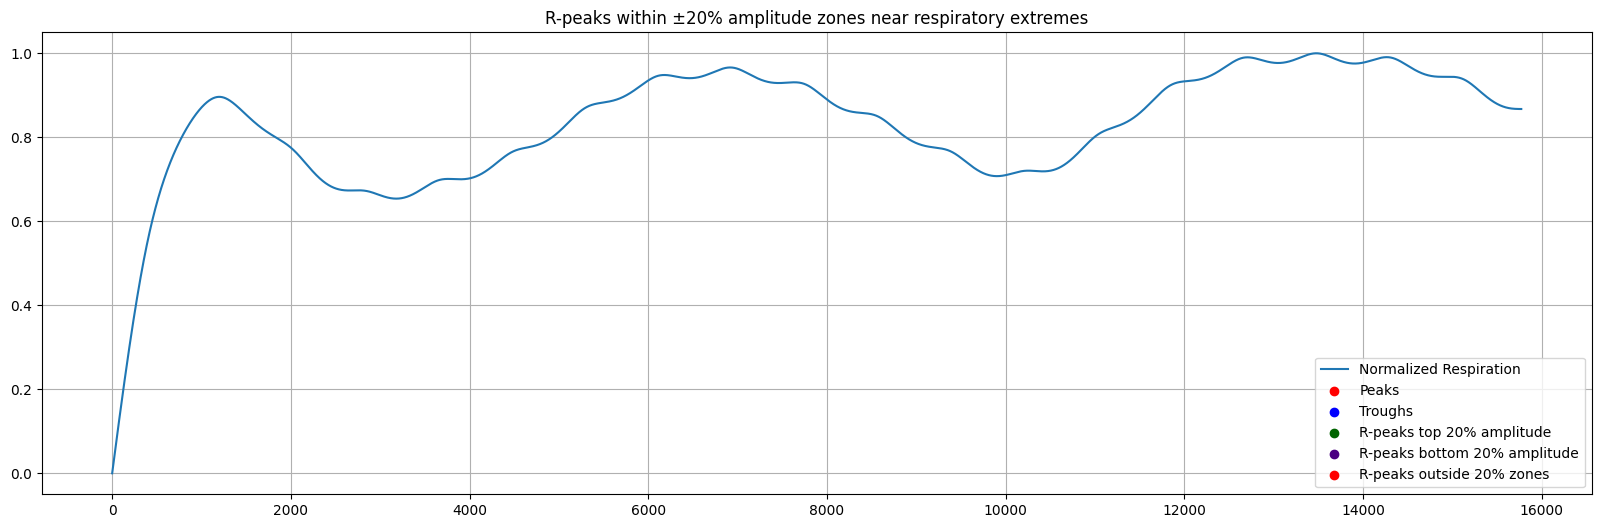

In [195]:
df_top, df_bottom, df_outside = select_peaks_near_extreme_amplitude(mean_smoothed_respiration, rpeaks_outside, 0.20)